# HBank - Based on 2-asset hank from SSJ


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sequence_jacobian import simple, solved, combine, create_model  # functions
from sequence_jacobian import grids, hetblocks                       # modules

from sequence_jacobian import simple, solved, combine, create_model, grids, hetblocks
hh = hetblocks.hh_twoasset.hh

In [2]:
### my custom HH block

from numba import guvectorize
from sequence_jacobian.blocks.het_block import het
from sequence_jacobian import interpolate


def hh1_init(b1_grid, a1_grid, z1_grid, eis1):
    Va1 = (0.6 + 1.1 * b1_grid[:, np.newaxis] + a1_grid) ** (-1 / eis1) * np.ones((z1_grid.shape[0], 1, 1))
    Vb1 = (0.5 + b1_grid[:, np.newaxis] + 1.2 * a1_grid) ** (-1 / eis1) * np.ones((z1_grid.shape[0], 1, 1))
    return Va1, Vb1

def hh2_init(b2_grid, a2_grid, z2_grid, eis2):
    Va2 = (0.6 + 1.1 * b2_grid[:, np.newaxis] + a2_grid) ** (-1 / eis2) * np.ones((z2_grid.shape[0], 1, 1))
    Vb2 = (0.5 + b2_grid[:, np.newaxis] + 1.2 * a2_grid) ** (-1 / eis2) * np.ones((z2_grid.shape[0], 1, 1))
    return Va2, Vb2


def adjustment_costs1(a1, a1_grid, ra, chi0, chi1, chi2):
    adj_cost1 = get_Psi_and_deriv(a1, a1_grid, ra, chi0, chi1, chi2)[0]
    return adj_cost1

def adjustment_costs2(a2, a2_grid, ra, chi0, chi1, chi2):
    adj_cost2 = get_Psi_and_deriv(a2, a2_grid, ra, chi0, chi1, chi2)[0]
    return adj_cost2


def marginal_cost_grid1(a1_grid, ra, chi0, chi1, chi2):
    # precompute Psi1(a', a) on grid of (a', a) for steps 3 and 5
    Psi1 = get_Psi_and_deriv(a1_grid[:, np.newaxis],
                             a1_grid[np.newaxis, :], ra, chi0, chi1, chi2)[1]
    return Psi1

def marginal_cost_grid2(a2_grid, ra, chi0, chi1, chi2):
    # precompute Psi1(a', a) on grid of (a', a) for steps 3 and 5
    Psi1 = get_Psi_and_deriv(a2_grid[:, np.newaxis],
                             a2_grid[np.newaxis, :], ra, chi0, chi1, chi2)[1]
    return Psi1


# policy and bacward order as in grid!
@het(exogenous='Pi1', policy=['b1', 'a1'], backward=['Vb1', 'Va1'],
     hetinputs=[marginal_cost_grid1], hetoutputs=[adjustment_costs1], backward_init=hh1_init)  
def hh1(Va1_p, Vb1_p, a1_grid, b1_grid, z1_grid, e1_grid, k1_grid, beta1, eis1, rb, ra, chi0, chi1, chi2, Psi1):
    # === STEP 2: Wb(z, b', a') and Wa(z, b', a') ===
    # (take discounted expectation of tomorrow's value function)
    Wb = beta1 * Vb1_p
    Wa = beta1 * Va1_p
    W_ratio = Wa / Wb

    # === STEP 3: a'(z, b', a) for UNCONSTRAINED ===

    # for each (z, b', a), linearly interpolate to find a' between gridpoints
    # satisfying optimality condition W_ratio == 1+Psi1
    i, pi = lhs_equals_rhs_interpolate(W_ratio, 1 + Psi1)

    # use same interpolation to get Wb and then c
    a_endo_unc = interpolate.apply_coord(i, pi, a1_grid)
    c_endo_unc = interpolate.apply_coord(i, pi, Wb) ** (-eis1)

    # === STEP 4: b'(z, b, a), a'(z, b, a) for UNCONSTRAINED ===

    # solve out budget constraint to get b(z, b', a)
    b_endo = (c_endo_unc + a_endo_unc + addouter(-z1_grid, b1_grid, -(1 + ra) * a1_grid)
              + get_Psi_and_deriv(a_endo_unc, a1_grid, ra, chi0, chi1, chi2)[0]) / (1 + rb)

    # interpolate this b' -> b mapping to get b -> b', so we have b'(z, b, a)
    # and also use interpolation to get a'(z, b, a)
    # (note utils.interpolate.interpolate_coord and utils.interpolate.apply_coord work on last axis,
    #  so we need to swap 'b' to the last axis, then back when done)
    i, pi = interpolate.interpolate_coord(b_endo.swapaxes(1, 2), b1_grid)
    a_unc = interpolate.apply_coord(i, pi, a_endo_unc.swapaxes(1, 2)).swapaxes(1, 2)
    b_unc = interpolate.apply_coord(i, pi, b1_grid).swapaxes(1, 2)

    # === STEP 5: a'(z, kappa, a) for CONSTRAINED ===

    # for each (z, kappa, a), linearly interpolate to find a' between gridpoints
    # satisfying optimality condition W_ratio/(1+kappa) == 1+Psi1, assuming b'=0
    lhs_con = W_ratio[:, 0:1, :] / (1 + k1_grid[np.newaxis, :, np.newaxis])
    i, pi = lhs_equals_rhs_interpolate(lhs_con, 1 + Psi1)

    # use same interpolation to get Wb and then c
    a_endo_con = interpolate.apply_coord(i, pi, a1_grid)
    c_endo_con = ((1 + k1_grid[np.newaxis, :, np.newaxis]) ** (-eis1)
                  * interpolate.apply_coord(i, pi, Wb[:, 0:1, :]) ** (-eis1))

    # === STEP 6: a'(z, b, a) for CONSTRAINED ===

    # solve out budget constraint to get b(z, kappa, a), enforcing b'=0
    b_endo = (c_endo_con + a_endo_con
              + addouter(-z1_grid, np.full(len(k1_grid), b1_grid[0]), -(1 + ra) * a1_grid)
              + get_Psi_and_deriv(a_endo_con, a1_grid, ra, chi0, chi1, chi2)[0]) / (1 + rb)

    # interpolate this kappa -> b mapping to get b -> kappa
    # then use the interpolated kappa to get a', so we have a'(z, b, a)
    # (utils.interpolate.interpolate_y does this in one swoop, but since it works on last
    #  axis, we need to swap kappa to last axis, and then b back to middle when done)
    a_con = interpolate.interpolate_y(b_endo.swapaxes(1, 2), b1_grid,
                                      a_endo_con.swapaxes(1, 2)).swapaxes(1, 2)

    # === STEP 7: obtain policy functions and update derivatives of value function ===

    # combine unconstrained solution and constrained solution, choosing latter
    # when unconstrained goes below minimum b
    a1, b1 = a_unc.copy(), b_unc.copy()
    b1[b1 <= b1_grid[0]] = b1_grid[0]
    a1[b1 <= b1_grid[0]] = a_con[b1 <= b1_grid[0]]

    # calculate adjustment cost and its derivative
    Psi, _, Psi2 = get_Psi_and_deriv(a1, a1_grid, ra, chi0, chi1, chi2)

    # solve out budget constraint to get consumption and marginal utility
    c1 = addouter(z1_grid, (1 + rb) * b1_grid, (1 + ra) * a1_grid) - Psi - a1 - b1
    uc = c1 ** (-1 / eis1)
    uce1 = e1_grid[:, np.newaxis, np.newaxis] * uc

    # update derivatives of value function using envelope conditions
    Va1 = (1 + ra - Psi2) * uc
    Vb1 = (1 + rb) * uc

    return Va1, Vb1, a1, b1, c1, uce1



@het(exogenous='Pi2', policy=['b2', 'a2'], backward=['Vb2', 'Va2'],
     hetinputs=[marginal_cost_grid2], hetoutputs=[adjustment_costs2], backward_init=hh2_init)  
def hh2(Va2_p, Vb2_p, a2_grid, b2_grid, z2_grid, e2_grid, k2_grid, beta2, eis2, rb, ra, chi0, chi1, chi2, Psi1):
    # === STEP 2: Wb(z, b', a') and Wa(z, b', a') ===
    # (take discounted expectation of tomorrow's value function)
    Wb = beta2 * Vb2_p
    Wa = beta2 * Va2_p
    W_ratio = Wa / Wb

    # === STEP 3: a'(z, b', a) for UNCONSTRAINED ===

    # for each (z, b', a), linearly interpolate to find a' between gridpoints
    # satisfying optimality condition W_ratio == 1+Psi1
    i, pi = lhs_equals_rhs_interpolate(W_ratio, 1 + Psi1)

    # use same interpolation to get Wb and then c
    a_endo_unc = interpolate.apply_coord(i, pi, a2_grid)
    c_endo_unc = interpolate.apply_coord(i, pi, Wb) ** (-eis2)

    # === STEP 4: b'(z, b, a), a'(z, b, a) for UNCONSTRAINED ===

    # solve out budget constraint to get b(z, b', a)
    b_endo = (c_endo_unc + a_endo_unc + addouter(-z2_grid, b2_grid, -(1 + ra) * a2_grid)
              + get_Psi_and_deriv(a_endo_unc, a2_grid, ra, chi0, chi1, chi2)[0]) / (1 + rb)

    # interpolate this b' -> b mapping to get b -> b', so we have b'(z, b, a)
    # and also use interpolation to get a'(z, b, a)
    # (note utils.interpolate.interpolate_coord and utils.interpolate.apply_coord work on last axis,
    #  so we need to swap 'b' to the last axis, then back when done)
    i, pi = interpolate.interpolate_coord(b_endo.swapaxes(1, 2), b2_grid)
    a_unc = interpolate.apply_coord(i, pi, a_endo_unc.swapaxes(1, 2)).swapaxes(1, 2)
    b_unc = interpolate.apply_coord(i, pi, b2_grid).swapaxes(1, 2)

    # === STEP 5: a'(z, kappa, a) for CONSTRAINED ===

    # for each (z, kappa, a), linearly interpolate to find a' between gridpoints
    # satisfying optimality condition W_ratio/(1+kappa) == 1+Psi1, assuming b'=0
    lhs_con = W_ratio[:, 0:1, :] / (1 + k2_grid[np.newaxis, :, np.newaxis])
    i, pi = lhs_equals_rhs_interpolate(lhs_con, 1 + Psi1)

    # use same interpolation to get Wb and then c
    a_endo_con = interpolate.apply_coord(i, pi, a2_grid)
    c_endo_con = ((1 + k2_grid[np.newaxis, :, np.newaxis]) ** (-eis2)
                  * interpolate.apply_coord(i, pi, Wb[:, 0:1, :]) ** (-eis2))

    # === STEP 6: a'(z, b, a) for CONSTRAINED ===

    # solve out budget constraint to get b(z, kappa, a), enforcing b'=0
    b_endo = (c_endo_con + a_endo_con
              + addouter(-z2_grid, np.full(len(k2_grid), b2_grid[0]), -(1 + ra) * a2_grid)
              + get_Psi_and_deriv(a_endo_con, a2_grid, ra, chi0, chi1, chi2)[0]) / (1 + rb)

    # interpolate this kappa -> b mapping to get b -> kappa
    # then use the interpolated kappa to get a', so we have a'(z, b, a)
    # (utils.interpolate.interpolate_y does this in one swoop, but since it works on last
    #  axis, we need to swap kappa to last axis, and then b back to middle when done)
    a_con = interpolate.interpolate_y(b_endo.swapaxes(1, 2), b2_grid,
                                      a_endo_con.swapaxes(1, 2)).swapaxes(1, 2)

    # === STEP 7: obtain policy functions and update derivatives of value function ===

    # combine unconstrained solution and constrained solution, choosing latter
    # when unconstrained goes below minimum b
    a2, b2 = a_unc.copy(), b_unc.copy()
    b2[b2 <= b2_grid[0]] = b2_grid[0]
    a2[b2 <= b2_grid[0]] = a_con[b2 <= b2_grid[0]]

    # calculate adjustment cost and its derivative
    Psi, _, Psi2 = get_Psi_and_deriv(a2, a2_grid, ra, chi0, chi1, chi2)

    # solve out budget constraint to get consumption and marginal utility
    c2 = addouter(z2_grid, (1 + rb) * b2_grid, (1 + ra) * a2_grid) - Psi - a2 - b2
    uc2 = c2 ** (-1 / eis2)
    uce2 = e2_grid[:, np.newaxis, np.newaxis] * uc2

    # update derivatives of value function using envelope conditions
    Va2 = (1 + ra - Psi2) * uc2
    Vb2 = (1 + rb) * uc2

    return Va2, Vb2, a2, b2, c2, uce2


'''Supporting functions for HA block'''

def get_Psi_and_deriv(ap, a, ra, chi0, chi1, chi2):
    """Adjustment cost Psi(ap, a) and its derivatives with respect to
    first argument (ap) and second argument (a)"""
    # this is adjusted for the original code to resemble the julia code
    a_with_return = (1 + ra) * a
    a_change = ap - a_with_return
    abs_a_change = np.abs(a_change)
    sign_change = np.sign(a_change)

    adj_denominator = a + chi0
    Psi = chi1 / chi2 * (abs_a_change / adj_denominator) ** (chi2) *  adj_denominator
    Psi1 = chi1  * sign_change * abs_a_change ** (chi2 - 1) * adj_denominator ** (1 - chi2 )
    Psi2 = - (1 + ra) * Psi1 - chi1 * abs_a_change ** (chi2) * adj_denominator ** (-chi2 - 1) * adj_denominator + chi1 / chi2 * (abs_a_change / adj_denominator) ** (chi2)

    return Psi, Psi1, Psi2




def matrix_times_first_dim(A, X):
    """Take matrix A times vector X[:, i1, i2, i3, ... , in] separately
    for each i1, i2, i3, ..., in. Same output as A @ X if X is 1D or 2D"""
    # flatten all dimensions of X except first, then multiply, then restore shape
    return (A @ X.reshape(X.shape[0], -1)).reshape(X.shape)


def addouter(z, b, a):
    """Take outer sum of three arguments: result[i, j, k] = z[i] + b[j] + a[k]"""
    return z[:, np.newaxis, np.newaxis] + b[:, np.newaxis] + a


@guvectorize(['void(float64[:], float64[:,:], uint32[:], float64[:])'], '(ni),(ni,nj)->(nj),(nj)')
def lhs_equals_rhs_interpolate(lhs, rhs, iout, piout):
    """
    Given lhs (i) and rhs (i,j), for each j, find the i such that

    lhs[i] > rhs[i,j] and lhs[i+1] < rhs[i+1,j]

    i.e. where given j, lhs == rhs in between i and i+1.

    Also return the pi such that

    pi*(lhs[i] - rhs[i,j]) + (1-pi)*(lhs[i+1] - rhs[i+1,j]) == 0

    i.e. such that the point at pi*i + (1-pi)*(i+1) satisfies lhs == rhs by linear interpolation.

    If lhs[0] < rhs[0,j] already, just return u=0 and pi=1.

    ***IMPORTANT: Assumes that solution i is monotonically increasing in j
    and that lhs - rhs is monotonically decreasing in i.***
    """

    ni, nj = rhs.shape
    assert len(lhs) == ni

    i = 0
    for j in range(nj):
        while True:
            if lhs[i] < rhs[i, j]:
                break
            elif i < nj - 1:
                i += 1
            else:
                break

        if i == 0:
            iout[j] = 0
            piout[j] = 1
        else:
            iout[j] = i - 1
            err_upper = rhs[i, j] - lhs[i]
            err_lower = rhs[i - 1, j] - lhs[i - 1]
            piout[j] = err_upper / (err_upper - err_lower)

            
def make_grids1(bmax, amax, kmax, nB, nA, nK, nZ, rho_z, sigma_z, lam, Y, zeta):
    b1_grid = grids.agrid(amax=bmax, n=nB)
    a1_grid = grids.agrid(amax=amax, n=nA)
    k1_grid = grids.agrid(amax=kmax, n=nK)[::-1].copy()


    if nZ == 33:
        # Load files and process them (converting from Julia to Python)
        import numpy as np
        
        # In Python, we need to use numpy.loadtxt instead of readdlm
        markov_ctstime = np.loadtxt("ymarkov_combined.txt")
        loge_ctstime = np.loadtxt("ygrid_combined.txt")

        import scipy.linalg
        markov_distime = scipy.linalg.expm(markov_ctstime)
        row_sums = markov_distime.sum(axis=1)
        markov_distime = markov_distime / row_sums[:, np.newaxis]

        eigenvalues, left_eigenvectors = np.linalg.eig(markov_distime.T)
            
            # Find the eigenvalue closest to 1
        idx = np.argmin(np.abs(eigenvalues - 1.0))
            
            # Get the corresponding eigenvector
        stationary = np.real(left_eigenvectors[:, idx])
            
            # Normalize to sum to 1
        stationary = stationary / np.sum(stationary)
 
        e_distime = np.exp(loge_ctstime).flatten()  # equivalent to vec(exp.(loge_ctstime))

        expected_value = sum(e_distime * stationary)

        ## correct for lambda 

        expected_value = sum( ((e_distime)**(1+zeta * np.log(Y))) ** (1-lam) * stationary)
        e1_grid = ((e_distime)**(1+zeta * np.log(Y))) ** (1-lam)  / expected_value
        Pi1 = markov_distime

    else:
        # Use Rouwenhorst method for other values of nZ
        e1_grid, _, Pi1 = grids.markov_rouwenhorst(rho=rho_z, sigma=sigma_z, N=nZ)
    
    
    return b1_grid, a1_grid, k1_grid, e1_grid, Pi1

def make_grids2(bmax, amax, kmax, nB, nA, nK, nZ, rho_z, sigma_z, lam, Y, zeta):
    b2_grid = grids.agrid(amax=bmax, n=nB)
    a2_grid = grids.agrid(amax=amax, n=nA)
    k2_grid = grids.agrid(amax=kmax, n=nK)[::-1].copy()


    if nZ == 33:
        # Load files and process them (converting from Julia to Python)
        import numpy as np
        
        # In Python, we need to use numpy.loadtxt instead of readdlm
        markov_ctstime = np.loadtxt("ymarkov_combined.txt")
        loge_ctstime = np.loadtxt("ygrid_combined.txt")

        import scipy.linalg
        markov_distime = scipy.linalg.expm(markov_ctstime)
        row_sums = markov_distime.sum(axis=1)
        markov_distime = markov_distime / row_sums[:, np.newaxis]

        eigenvalues, left_eigenvectors = np.linalg.eig(markov_distime.T)
            
            # Find the eigenvalue closest to 1
        idx = np.argmin(np.abs(eigenvalues - 1.0))
            
            # Get the corresponding eigenvector
        stationary = np.real(left_eigenvectors[:, idx])
            
            # Normalize to sum to 1
        stationary = stationary / np.sum(stationary)
 
        e_distime = np.exp(loge_ctstime).flatten()  # equivalent to vec(exp.(loge_ctstime))





        expected_value = sum( ((e_distime)**(1+zeta * np.log(Y))) ** (1-lam) * stationary)
        e2_grid = ((e_distime)**(1+zeta * np.log(Y))) ** (1-lam)  / expected_value
        Pi2 = markov_distime

    else:
        # Use Rouwenhorst method for other values of nZ
        e2_grid, _, Pi2 = grids.markov_rouwenhorst(rho=rho_z, sigma=sigma_z, N=nZ)
    
    
    return b2_grid, a2_grid, k2_grid, e2_grid, Pi2


def income1(e1_grid, T, Y, lam, alpha):
    z1_grid = ((1 - alpha) * Y - T) * e1_grid

    return z1_grid

def income2(e2_grid, T, Y, lam, alpha):
    z2_grid = ((1 - alpha) * Y - T) * e2_grid
    return z2_grid

In [23]:
@simple 
def aggregate_hh(share_hh1, C1, C2, ADJ_COST1, ADJ_COST2, A1, A2, B1, B2, UCE1, UCE2, 
                 GINI_A1, GINI_A2, GINI_B1, GINI_B2, GINI_C1, GINI_C2, GINI_WEALTH1, GINI_WEALTH2):

    # Aggregate quantities (existing code)
    C = share_hh1 * C1 + (1 - share_hh1) * C2
    A = share_hh1 * A1 + (1 - share_hh1) * A2
    B = share_hh1 * B1 + (1 - share_hh1) * B2
    ADJ_COST = share_hh1 * ADJ_COST1 + (1 - share_hh1) * ADJ_COST2
    UCE = share_hh1 * UCE1 + (1 - share_hh1) * UCE2
    
    # Calculate total Gini coefficients using decomposition formula
    # Gini_total = w₁ × Gini₁ × (μ₁/μ) + w₂ × Gini₂ × (μ₂/μ) + w₁ × w₂ × |μ₁ - μ₂|/μ
    
    # Population shares
    w1 = share_hh1
    w2 = 1 - share_hh1
    
    # Helper function for differentiable absolute value
    def diff_abs(x):
        # Use smooth approximation: sqrt(x^2 + eps) where eps is small
        eps = 1e-8
        return (x**2 + eps)**0.5
    
    # For illiquid assets (A)
    mu_a = A  # total mean
    within_group_a = w1 * GINI_A1 * (A1/mu_a) + w2 * GINI_A2 * (A2/mu_a)
    between_group_a = w1 * w2 * diff_abs(A1 - A2) / mu_a
    GINI_A_TOTAL = within_group_a + between_group_a
    
    # For liquid assets (B)
    mu_b = B  # total mean
    within_group_b = w1 * GINI_B1 * (B1/mu_b) + w2 * GINI_B2 * (B2/mu_b)
    between_group_b = w1 * w2 * diff_abs(B1 - B2) / mu_b
    GINI_B_TOTAL = within_group_b + between_group_b
    
    # For consumption (C)
    mu_c = C  # total mean
    within_group_c = w1 * GINI_C1 * (C1/mu_c) + w2 * GINI_C2 * (C2/mu_c)
    between_group_c = w1 * w2 * diff_abs(C1 - C2) / mu_c
    GINI_C_TOTAL = within_group_c + between_group_c
    
    # For total wealth (A + B)
    WEALTH_TOTAL = A + B
    WEALTH1 = A1 + B1
    WEALTH2 = A2 + B2
    mu_wealth = WEALTH_TOTAL  # total mean
    within_group_wealth = w1 * GINI_WEALTH1 * (WEALTH1/mu_wealth) + w2 * GINI_WEALTH2 * (WEALTH2/mu_wealth)
    between_group_wealth = w1 * w2 * diff_abs(WEALTH1 - WEALTH2) / mu_wealth
    GINI_WEALTH_TOTAL = within_group_wealth + between_group_wealth
    
    return C, A, B, ADJ_COST, UCE, GINI_A_TOTAL, GINI_B_TOTAL, GINI_C_TOTAL, GINI_WEALTH_TOTAL, within_group_c, between_group_c

In [4]:
def calculate_gini(values, weights):
    """
    Calculate Gini coefficient given values and their corresponding weights/probabilities
    
    Parameters:
    values: array of values (e.g., a1)
    weights: array of weights/probabilities (e.g., D)
    
    Returns:
    gini: Gini coefficient
    """
    # Flatten arrays and ensure they're 1D
    values_flat = values.flatten()
    weights_flat = weights.flatten()
    
    # Remove any zero weights
    mask = weights_flat > 0
    values_flat = values_flat[mask]
    weights_flat = weights_flat[mask]
    
    # Sort by values
    sorted_indices = np.argsort(values_flat)
    values_sorted = values_flat[sorted_indices]
    weights_sorted = weights_flat[sorted_indices]
    
    # Normalize weights to sum to 1
    weights_sorted = weights_sorted / weights_sorted.sum()
    
    # Calculate cumulative shares
    cumulative_weights = np.cumsum(weights_sorted)
    cumulative_values = np.cumsum(values_sorted * weights_sorted)
    
    # Normalize cumulative values
    total_value = cumulative_values[-1]
    if total_value <= 0:
        return 0.0
    
    cumulative_value_share = cumulative_values / total_value
    
    # Calculate Gini coefficient using trapezoidal rule
    # Gini = 1 - 2 * Area under Lorenz curve
    lorenz_area = np.trapz(cumulative_value_share, cumulative_weights)
    gini = 1 - 2 * lorenz_area
    
    return gini


In [24]:

# def hh1_var(a1,A1,b1,B1,c1,C1):
#     a1_var = (a1 - A1)**2
#     b1_var = (b1 - B1)**2
#     c1_var = (c1 - C1)**2
#     return a1_var, b1_var, c1_var

# def hh2_var(a2,A2,b2,B2,c2,C2):
#     a2_var = (a2 - A2)**2
#     b2_var = (b2 - B2)**2
#     c2_var = (c2 - C2)**2
#     return a2_var, b2_var, c2_var


def hh1_inner(D,a1,b1,c1):

    wealth_1 = a1 + b1 

    gini_a1_temp = calculate_gini(a1,D)
    gini_b1_temp = calculate_gini(b1,D)
    gini_c1_temp = calculate_gini(c1,D)
    gini_wealth1_temp = calculate_gini(wealth_1,D)

    gini_a1 = np.full_like(D, gini_a1_temp)
    gini_b1 = np.full_like(D, gini_b1_temp)
    gini_c1 = np.full_like(D, gini_c1_temp)
    gini_wealth1 = np.full_like(D, gini_wealth1_temp)

    return gini_a1, gini_b1, gini_c1, gini_wealth1


def hh2_inner(D,a2,b2,c2):

    wealth_2 = a2 + b2 

    gini_a2_temp = calculate_gini(a2,D)
    gini_b2_temp = calculate_gini(b2,D)
    gini_c2_temp = calculate_gini(c2,D)
    gini_wealth2_temp = calculate_gini(wealth_2,D)

    gini_a2 = np.full_like(D, gini_a2_temp)
    gini_b2 = np.full_like(D, gini_b2_temp)
    gini_c2 = np.full_like(D, gini_c2_temp)
    gini_wealth2 = np.full_like(D, gini_wealth2_temp)

    return gini_a2, gini_b2, gini_c2, gini_wealth2


hh1_ext = hh1.add_hetinputs([income1, make_grids1])
hh1_ext = hh1_ext.add_hetoutputs([hh1_inner])


hh2_ext = hh2.add_hetinputs([income2, make_grids2])
hh2_ext = hh2_ext.add_hetoutputs([hh2_inner])

Testing HH


In [7]:
blocks = [hh1_ext, hh2_ext, aggregate_hh]
hank_hh = create_model(blocks, name='Two-Asset HANK HH')
print(*hank_hh.blocks, sep='\n')

print(f"Inputs: {hank_hh.inputs}")
print(f"Outputs: {hank_hh.outputs}")

calibration_hh = {
               'rb': 0.00,
               'ra': 0.00975,
               'chi0': 0.1,
               'chi1': 23.3360645809,
               'chi2': 2.0154,
                'beta1': 0.98261,
                'beta2': 0.943,
                'T': 0.15,
                'eis1': 0.5,
                'eis2': 2.0,
                'share_hh1': 1-0.172,
                'w': 0.7,
                'N' : 1.0,
                'Y': 1.0,
                'alpha': 0.35,
                'lam': 0.18,
                'zeta ': 1.0,
               'nZ': 33,
               'nB': 40,
               'nA': 30,
               'nK': 30,
               'bmax': 250,
               'amax': 1200,
               'kmax': 1,
               'rho_z': 0.966, 
               'sigma_z': 0.92,
               'zeta': -0.5,}

ssh = hank_hh.steady_state(calibration_hh)

print(calibration_hh)
print(ssh)
print(f"A: {ssh['A']}")
print(f"B: {ssh['B']}")
print(f"C: {ssh['C']}")
print(f"UCE: {ssh['UCE']}")
print(f"CHI: {ssh['ADJ_COST']}")
#print(f"z_grid: {ssh.internals['hh']['z_grid']}")

<HetBlock 'hh2' with hetinput 'make_grids2_marginal_cost_grid2' and with hetoutput `hh2_inner_adjustment_costs2'>
<HetBlock 'hh1' with hetinput 'make_grids1_marginal_cost_grid1' and with hetoutput `hh1_inner_adjustment_costs1'>
<SimpleBlock 'aggregate_hh'>
Inputs: ['beta1', 'eis1', 'rb', 'ra', 'chi0', 'chi1', 'chi2', 'T', 'Y', 'lam', 'alpha', 'bmax', 'amax', 'kmax', 'nB', 'nA', 'nK', 'nZ', 'rho_z', 'sigma_z', 'zeta', 'beta2', 'eis2', 'share_hh1']
Outputs: ['A1', 'B1', 'C1', 'UCE1', 'ADJ_COST1', 'GINI_A1', 'GINI_B1', 'GINI_C1', 'GINI_WEALTH1', 'A2', 'B2', 'C2', 'UCE2', 'ADJ_COST2', 'GINI_A2', 'GINI_B2', 'GINI_C2', 'GINI_WEALTH2', 'C', 'A', 'B', 'ADJ_COST', 'UCE', 'GINI_A_TOTAL', 'GINI_B_TOTAL', 'GINI_C_TOTAL', 'GINI_WEALTH_TOTAL']


C:\Users\Piotr\AppData\Local\Temp\ipykernel_20700\1332208378.py:42: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.


{'rb': 0.0, 'ra': 0.00975, 'chi0': 0.1, 'chi1': 23.3360645809, 'chi2': 2.0154, 'beta1': 0.98261, 'beta2': 0.943, 'T': 0.15, 'eis1': 0.5, 'eis2': 2.0, 'share_hh1': 0.8280000000000001, 'w': 0.7, 'N': 1.0, 'Y': 1.0, 'alpha': 0.35, 'lam': 0.18, 'zeta ': 1.0, 'nZ': 33, 'nB': 40, 'nA': 30, 'nK': 30, 'bmax': 250, 'amax': 1200, 'kmax': 1, 'rho_z': 0.966, 'sigma_z': 0.92, 'zeta': -0.5}
<SteadyStateDict: ['beta1', 'eis1', 'rb', 'ra', 'chi0', 'chi1', 'chi2', 'T', 'Y', 'lam', 'alpha', 'bmax', 'amax', 'kmax', 'nB', 'nA', 'nK', 'nZ', 'rho_z', 'sigma_z', 'zeta', 'beta2', 'eis2', 'share_hh1', 'A2', 'B2', 'C2', 'UCE2', 'ADJ_COST2', 'GINI_A2', 'GINI_B2', 'GINI_C2', 'GINI_WEALTH2', 'A1', 'B1', 'C1', 'UCE1', 'ADJ_COST1', 'GINI_A1', 'GINI_B1', 'GINI_C1', 'GINI_WEALTH1', 'C', 'A', 'B', 'ADJ_COST', 'UCE', 'GINI_A_TOTAL', 'GINI_B_TOTAL', 'GINI_C_TOTAL', 'GINI_WEALTH_TOTAL'], internals=['hh2', 'hh1']>
A: 13.690008518286282
B: 2.49646728949462
C: 0.6169200358972234
UCE: 2.9726210154387704
CHI: 0.016557615355717

In [37]:
print(f"GINI_C1: {ssh['GINI_C1']}")
print(f"GINI_C2: {ssh['GINI_C2']}")
print(f"GINI_C_TOTAL: {ssh['GINI_C_TOTAL']}")
print(f"UCE: {ssh['UCE']}")
print(f"CHI: {ssh['ADJ_COST']}")

GINI_C1: 0.3220341990794544
GINI_C2: 0.390938100934635
GINI_C_TOTAL: 0.3642369403705608
UCE: 2.9726210154387704
CHI: 0.016557615355717845


In [8]:
targets = {
    "Y": 1.00,
    "n_inter": 0.13*4,
    "T":0.15,
    "B_sum":2.4964672894917257,
    "A_sum":13.69000851827007,
    "theta":4,
    "rb":0.0,    
    "N": 1.0
}

Calibrate steady state


In [9]:
@simple
def smart_steady(A_sum,  B_sum, theta, Y,  T, n_inter,  rb, alpha, delta, f, N):

    # this is copied from the Julia code
    d = (theta-1)*n_inter
    K = A_sum + d
    rk = alpha * Y/K - delta
    m = n_inter*(1-(1-f)*(1 + rb+ theta*(rk-rb)))
    k_inter = theta*n_inter
    k_fund = K - k_inter
    ra = (rk - rb) / ( 1- d / K) + rb
    I = K*delta 
    b_gov = B_sum - d
    G = T -  rb * b_gov
    Z = Y / K**alpha *N**(1-alpha)
    rb_ante = rb
    return  d, K, rk, m, k_inter, k_fund, ra, I, b_gov, G, Z, rb_ante

@simple
def market_clearing(Y, C, ADJ_COST, I, G, B_sum, B, A_sum, A):
    #Goods Market Clearing Condition
    goods_mkt = Y- C - ADJ_COST - I-G 

    #Liquid Asset Market Clearing Condition
    liquid_mkt = B_sum-B

    #Illiquid Asset Market Clearing Condition
    illiquid_mkt = A_sum-A

    return goods_mkt, liquid_mkt, illiquid_mkt 

@simple 
def steady_auxilliary(theta, rk, rb, ksi, delta, alpha, Y, K, N):
    iota  = delta
    gamma = delta
    mpk   = alpha*(Y/K)
    rn = theta*(rk-rb)+rb
    w = (1-alpha)*Y/N
    gamma0 = 1/((1-ksi)*delta ** (-ksi))
    gamma1 = delta - gamma0 * delta ** (1-ksi)
    return  iota, gamma, mpk, rn, gamma0, gamma1

In [10]:
blocks_ss = [smart_steady, market_clearing, hh1_ext, hh2_ext, aggregate_hh, steady_auxilliary]

hank_ss = create_model(blocks_ss, name='Two-Asset HANK SS')

print(hank_ss)
print(f"Inputs: {hank_ss.inputs}")
print(f"Outputs: {hank_ss.outputs}")


calibration = { 'chi0': 0.1,
                'chi2': 2.0154,
                'beta2': 0.943,
                'T': 0.15,
                'eis1': 0.5,
                'eis2': 2.0,
                'share_hh1': 1-0.172,
                'Y': 1.0,
                'alpha': 0.35,
                'lam': 0.18,
                'rho_z': 0.0,
                'sigma_z': 0.0,
               'nZ': 33,
               'nB': 40,
               'nA': 30,
               'nK': 30,
               'bmax': 250,
               'amax': 1200,
               'kmax': 1,
                'N' : targets["N"],
                'B_sum': targets["B_sum"],
                'A_sum': targets["A_sum"],
                'T': targets["T"],
                'rb': targets["rb"],
                'rb_ante': targets["rb"],
                'theta': targets["theta"],
                'n_inter': targets["n_inter"],
                'Y': targets["Y"],
                'delta': 0.0144485,
                'f': 0.05,
                'ksi': 0.5,
                'zeta': - 0.5,
               }


unknowns_ss = {'beta1': 0.9837809152199475, 'chi1': 15.47779125718972}
targets_ss = {'illiquid_mkt': 0., 'liquid_mkt':0.}

cali = hank_ss.solve_steady_state(calibration, unknowns_ss, targets_ss, solver='broyden_custom')


print(f"ra: {cali['ra']}")
print(f"B: {cali['B']}")
print(f"goods_mkt: {cali['goods_mkt']}")
print(f"liquid_mkt: {cali['liquid_mkt']}")
print(f"illiquid_mkt: {cali['illiquid_mkt']}")

<Model 'Two-Asset HANK SS'>
Inputs: ['A_sum', 'B_sum', 'theta', 'Y', 'T', 'n_inter', 'rb', 'alpha', 'delta', 'f', 'N', 'beta1', 'eis1', 'chi0', 'chi1', 'chi2', 'lam', 'bmax', 'amax', 'kmax', 'nB', 'nA', 'nK', 'nZ', 'rho_z', 'sigma_z', 'zeta', 'beta2', 'eis2', 'share_hh1', 'ksi']
Outputs: ['d', 'K', 'rk', 'm', 'k_inter', 'k_fund', 'ra', 'I', 'b_gov', 'G', 'Z', 'rb_ante', 'goods_mkt', 'liquid_mkt', 'illiquid_mkt', 'A1', 'B1', 'C1', 'UCE1', 'ADJ_COST1', 'GINI_A1', 'GINI_B1', 'GINI_C1', 'GINI_WEALTH1', 'A2', 'B2', 'C2', 'UCE2', 'ADJ_COST2', 'GINI_A2', 'GINI_B2', 'GINI_C2', 'GINI_WEALTH2', 'C', 'A', 'B', 'ADJ_COST', 'UCE', 'GINI_A_TOTAL', 'GINI_B_TOTAL', 'GINI_C_TOTAL', 'GINI_WEALTH_TOTAL', 'iota', 'gamma', 'mpk', 'rn', 'gamma0', 'gamma1']


C:\Users\Piotr\AppData\Local\Temp\ipykernel_20700\1332208378.py:42: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.


ra: 0.009471159331328109
B: 2.496467289491611
goods_mkt: -7.812923222272339e-08
liquid_mkt: 1.1457501614131615e-13
illiquid_mkt: 1.0658141036401503e-13


### Equations

In [25]:
@solved(unknowns={'I': cali['K'] * cali['delta'] , 'K':cali['K'], 'Q':1.0 }, targets=['rk_res', 'capital_res', 'q_res'], solver="broyden_custom")
def capital_solved(rk, Y, Q, K, I, alpha, delta, ksi, gamma0, gamma1):
    
    #Law of motion of capital

    iota = (I/K(-1))
    mpk  = alpha*(Y/K(-1))
    gamma = iota**(1-ksi)*gamma0+gamma1

    rk_res =  1 + rk - (mpk+  Q*(1+gamma-delta)-iota)/(Q(-1))
    capital_res = (1 - delta + gamma) * K(-1) - K
    q_res = Q - (1/(gamma0 * (1-ksi) * iota**(-ksi) ))
    return rk_res, capital_res, q_res



@simple
def labor(Y, K, Z, alpha):
    #Labor Demand
    N    = (Y / Z / K(-1) ** alpha) ** (1 / (1 - alpha))
    #Marginal Product of Labor
    w     = (1-alpha)*(Y/N(-1))

    return N, w


@simple
def capital_noadj(Y,K, alpha, delta):
    
    #Law of motion of capital
    rk = alpha * (Y/K(-1)) - delta 
    I = K  -  K(-1) * (1- delta)    
    return rk, I 

@simple
def intermediation_P1(Q, rk, rb, n_inter, n_gov, K, theta, theta0, theta_rk,theta_rb,decay):
    #Financial Frictions


    theta_res = theta - theta0 - theta_rk*rk(+1)- theta_rb*rb(+1) - decay * theta(+1)
    #theta   = theta0+theta1*(rk(+1)-rb(+1))
    
    
    #Intermediary Capital
    k_inter =  theta * n_inter /Q
    k_gov   =  theta * n_gov / Q
    #Return on net worth
    rn =  theta(-1)*(rk-rb)+rb

    # Liquidity
    d       = (theta -1)*(n_inter + n_gov)
    # K_fund 

    k_fund = K- (k_inter+k_gov)
    return theta_res, k_inter, k_gov, d, k_fund, rn

@simple 
def intermediation_P2(theta, rk, rb, n_inter, m, f):
    #Intermediary net worth law of motion
    n_inter_val = (1-f)*(1+rb+theta(-1)*(rk-rb))*n_inter(-1)+ m - n_inter 
    return n_inter_val

@simple 
def intermediation_P3(Q, k_fund, n_inter, d, b_gov, rk, rn):
    #Definition Illiquid asset
    A_sum = Q*k_fund+n_inter

    #Definition Liquid Assets
    B_sum = d + b_gov

    #Return on Illiquid Asset
    ra = (rk*Q(-1)*k_fund(-1)+rn*n_inter(-1))/A_sum(-1)
    return A_sum, B_sum, ra


#Turn it into a solved combined block
intermediation = combine([intermediation_P1, intermediation_P2, intermediation_P3]) 

intermediation_solved = intermediation.solved(unknowns={'n_inter': targets['n_inter'],'theta': targets['theta']}, 
                                      targets=['n_inter_val','theta_res'],
                                      solver='broyden_custom')


In [26]:
print(intermediation_solved.inputs)

['Q', 'rk', 'rb', 'n_gov', 'K', 'theta0', 'theta_rk', 'theta_rb', 'decay', 'm', 'f', 'b_gov']


In [27]:
@simple
def capital_noadj(Y,K, alpha, delta):
    
    #Law of motion of capital
    rk = alpha * (Y/K(-1)) - delta 
    I = K  -  K(-1) * (1- delta)    
    return rk, I 

@simple
def intermediation_noadj_P1( rk, rb, n_inter, K, theta0, theta1):
    #Financial Frictions
    theta   = theta0+theta1*(rk(+1)-rb(+1))

    #Intermediary Capital
    k_inter = (theta*n_inter)
    #Return on net worth
    rn =  theta(-1)*(rk-rb)+rb

    # Liquidity
    d       = (theta -1)*n_inter
    # K_fund 
    k_fund = K- k_inter
    return theta, k_inter, d, k_fund, rn

@simple 
def intermediation_noadj_P2(theta, rk, rb, n_inter, m, f):
    #Intermediary net worth law of motion
    n_inter_val = (1-f)*(1+rb+theta(-1)*(rk-rb))*n_inter(-1)+m-n_inter
    return n_inter_val

@simple 
def intermediation_noadj_P3(k_fund, n_inter, d, b_gov, rk, rn):
    #Definition Illiquid asset
    A_sum = k_fund+n_inter

    #Definition Liquid Assets
    B_sum = d + b_gov

    #Return on Illiquid Asset
    ra = (rk*k_fund(-1)+rn*n_inter(-1))/A_sum(-1)
    return A_sum, B_sum, ra


#Turn it into a solved combined block
intermediation_noadj = combine([intermediation_noadj_P1, intermediation_noadj_P2, intermediation_noadj_P3]) 

# intermediation_solved = intermediation_noadj.solved(unknowns={'n_inter': (0.9*targets['n_inter'],1.1*targets['n_inter'])}, 
#                                       targets=['n_inter_val'],
#                                       solver='broyden_custom')


In [28]:
@simple 
def government(T, rb,b_gov, rn,n_gov):
    G =  T - (1+rb)*b_gov(-1) + b_gov + (1+rn)*n_gov(-1) - n_gov    
    return G

@simple 
def mon_pol(rb_ante):
    rb = rb_ante(-1)
    return rb    

@simple 
def government_dynamic(G, rb, b_gov, rn, n_gov):
    T = G + (1 + rb) * b_gov(-1) - b_gov - (1 + rn) * n_gov(-1) + n_gov
    return T

In [29]:
combined_gov = combine([mon_pol,government,intermediation_solved])


In [30]:
ha_block = combine([hh1_ext, hh2_ext, aggregate_hh]) 

hank_trans = create_model([market_clearing, ha_block ,intermediation_solved,capital_solved,
                      labor, government], name="HA Model")

print(hank_trans)
print(f"Inputs: {hank_trans.inputs}")
print(f"Outputs: {hank_trans.outputs}")



unknowns_ss_2 = {'Y': 1.0, 'rk': cali['rk']}  # provide bounds on beta for the solver
targets_ss_2 = ['goods_mkt','liquid_mkt']  # set the ss target


model_calibration = cali.copy()

# Add additional parameters needed for the model that aren't in cali


model_calibration['decay'] = 0.94
model_calibration['n_gov'] = 0.0

model_calibration['theta_rk'] = 25.0
model_calibration['theta_rb'] = -25.0

model_calibration['theta0'] = (1 - model_calibration['decay']) * model_calibration['theta'] - model_calibration['theta_rk'] * model_calibration['rk'] - model_calibration['theta_rb'] * model_calibration['rb']


cali_fin = hank_trans.solve_steady_state(model_calibration, unknowns_ss_2,targets_ss_2, solver='broyden_custom')


<Model 'HA Model'>
Inputs: ['Y', 'beta1', 'eis1', 'rb', 'chi0', 'chi1', 'chi2', 'T', 'lam', 'alpha', 'bmax', 'amax', 'kmax', 'nB', 'nA', 'nK', 'nZ', 'rho_z', 'sigma_z', 'zeta', 'beta2', 'eis2', 'share_hh1', 'rk', 'n_gov', 'theta0', 'theta_rk', 'theta_rb', 'decay', 'm', 'f', 'b_gov', 'delta', 'ksi', 'gamma0', 'gamma1', 'Z']
Outputs: ['goods_mkt', 'liquid_mkt', 'illiquid_mkt', 'A1', 'B1', 'C1', 'UCE1', 'ADJ_COST1', 'GINI_A1', 'GINI_B1', 'GINI_C1', 'GINI_WEALTH1', 'A2', 'B2', 'C2', 'UCE2', 'ADJ_COST2', 'GINI_A2', 'GINI_B2', 'GINI_C2', 'GINI_WEALTH2', 'C', 'A', 'B', 'ADJ_COST', 'UCE', 'GINI_A_TOTAL', 'GINI_B_TOTAL', 'GINI_C_TOTAL', 'GINI_WEALTH_TOTAL', 'within_group_c', 'between_group_c', 'theta_res', 'k_inter', 'k_gov', 'd', 'k_fund', 'rn', 'n_inter_val', 'A_sum', 'B_sum', 'ra', 'theta', 'n_inter', 'rk_res', 'capital_res', 'q_res', 'I', 'Q', 'K', 'N', 'w', 'G']


C:\Users\Piotr\AppData\Local\Temp\ipykernel_20700\1332208378.py:42: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.


In [38]:
J_ha = ha_block.jacobian(cali_fin, inputs=['Y', 'ra', 'rb', 'T'], T=300)

C:\Users\Piotr\AppData\Local\Temp\ipykernel_20700\1332208378.py:42: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.


In [39]:
time = 300  # <-- the length of the IRF


rho_bG = 0.95
eta = 0.5
eta_0  = 1
# Initialize arrays
s = eta_0 * eta ** np.arange(time)  # s_t = eta^t * s_0, where s_0 = eta_0 = 1
dbG = np.zeros(time)

# Calculate dbG recursively
for t in range(time):
    if t == 0:
        dbG[t] = rho_bG * s[t]  # dbG_0 = rho_bG * s_0
    else:
        dbG[t] = rho_bG * (dbG[t-1] + s[t])



# Renormalize so that dbG[3] = 4 (4th value, 0-indexed)
normalization_factor = 4 / dbG[3]
dbG = dbG * normalization_factor


shocks = {'n_gov': dbG, 'b_gov': dbG} 


hank_trans2 = create_model([market_clearing, ha_block ,intermediation_solved,capital_solved,
                      labor, government_dynamic, mon_pol], name="HA Model")


unknowns_td = ['Y','rk']
targets_td = ['liquid_mkt', 'illiquid_mkt' ]

irfs = hank_trans2.solve_impulse_linear(cali_fin, unknowns_td, targets_td, shocks, Js = {'ha_block': J_ha})


C:\Users\Piotr\AppData\Local\Temp\ipykernel_20700\1332208378.py:42: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.


In [18]:
def show_irfs(irfs_list, variables, labels=[" "], ylabel=r"Percentage points (dev. from ss)", T_plot=50, figsize=(18, 6)):
    if len(irfs_list) != len(labels):
        labels = [" "] * len(irfs_list)
    n_var = len(variables)
    fig, ax = plt.subplots(1, n_var, figsize=figsize, sharex=True)
    for i in range(n_var):
        # plot all irfs
        for j, irf in enumerate(irfs_list):
            ax[i].plot(irf[variables[i]][:50], label=labels[j])
        ax[i].set_title(variables[i])
        ax[i].set_xlabel(r"$t$")
        if i==0:
            ax[i].set_ylabel(ylabel)
        ax[i].legend()
    plt.show()

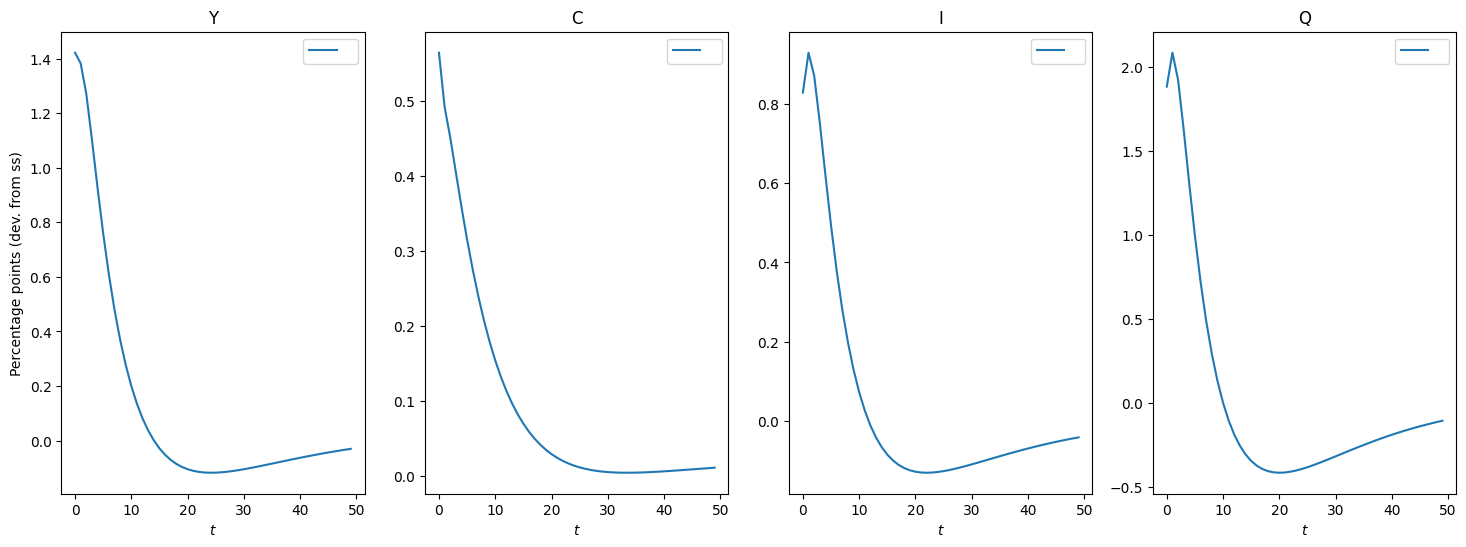

In [19]:
show_irfs([irfs], ['Y', 'C','I','Q' ])

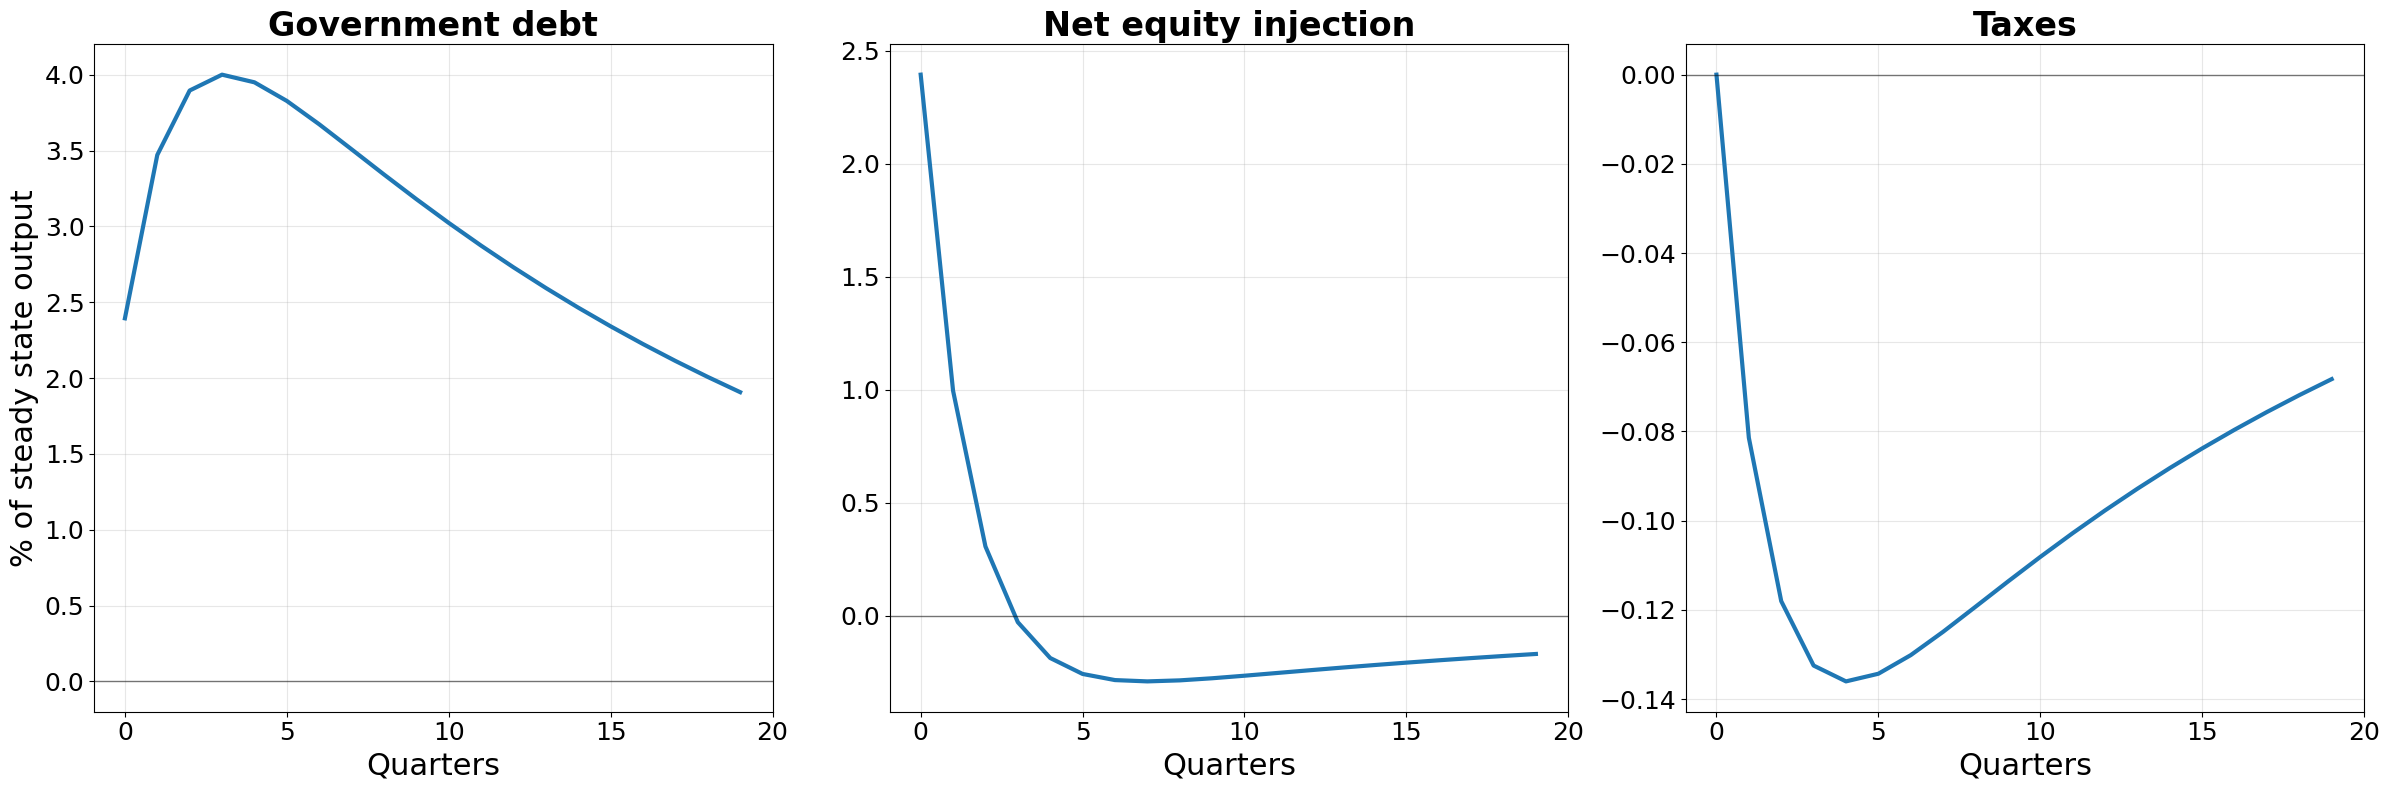

In [20]:
# Extract the relevant variables from the IRFs
bG_t = irfs['b_gov'][:20]  # Government debt
nG_t = irfs['n_gov'][:20]  # Government net worth
rn_t = irfs['rn'][:20]     # Return on net worth
T_t = irfs['T'][:20]       # Taxes

# Calculate nG_t - (1+rN)nG_{t-1}
# For t=0, we use steady state values for the lagged term
nG_flow = np.zeros(20)
nG_flow[0] = nG_t[0] - (1 + cali_fin['rn']) * cali_fin['n_gov']  # Initial flow using SS values
for t in range(1, 20):
    nG_flow[t] = nG_t[t] - (1 + cali_fin['rn']) * nG_t[t-1]


# Create the three-panel plot
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# Panel 1: Government debt
axes[0].plot(bG_t, linewidth=3)  # Same blue color and linewidth as macro plots
axes[0].set_title(r'Government debt', fontsize=24, fontweight='bold')
axes[0].set_ylabel('% of steady state output', fontsize=22)
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks([0, 5, 10, 15, 20])
axes[0].axhline(y=0, color='black', linewidth=1, alpha=0.5)
axes[0].tick_params(axis='both', which='major', labelsize=18)

# Panel 2: Government net worth flow
axes[1].plot(nG_flow, linewidth=3)  # Same blue color and linewidth as macro plots
axes[1].set_title(r'Net equity injection', fontsize=24, fontweight='bold')
axes[1].axhline(y=0, color='black', linewidth=1, alpha=0.5)
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks([0, 5, 10, 15, 20])
axes[1].tick_params(axis='both', which='major', labelsize=18)

# Panel 3: Taxes
axes[2].plot(T_t, linewidth=3)  # Same blue color and linewidth as macro plots
axes[2].set_title(r'Taxes', fontsize=24, fontweight='bold')
axes[2].grid(True, alpha=0.3)
axes[2].set_xticks([0, 5, 10, 15, 20])
axes[2].axhline(y=0, color='black', linewidth=1, alpha=0.5)
axes[2].tick_params(axis='both', which='major', labelsize=18)

# Set common labels
for ax in axes:
    ax.set_xlabel('Quarters', fontsize=22)

plt.tight_layout()
plt.savefig('policies.svg', format='svg', bbox_inches='tight', dpi=300)

plt.show()

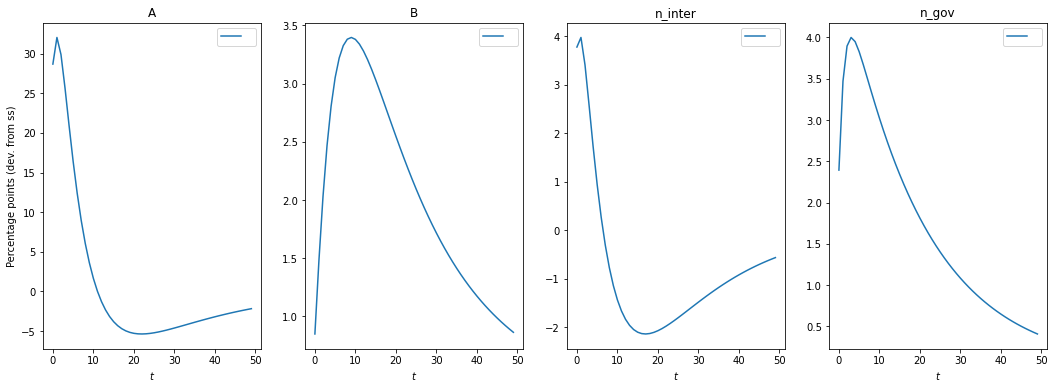

In [33]:
show_irfs([irfs], ['A', 'B' ,'n_inter', 'n_gov'],)

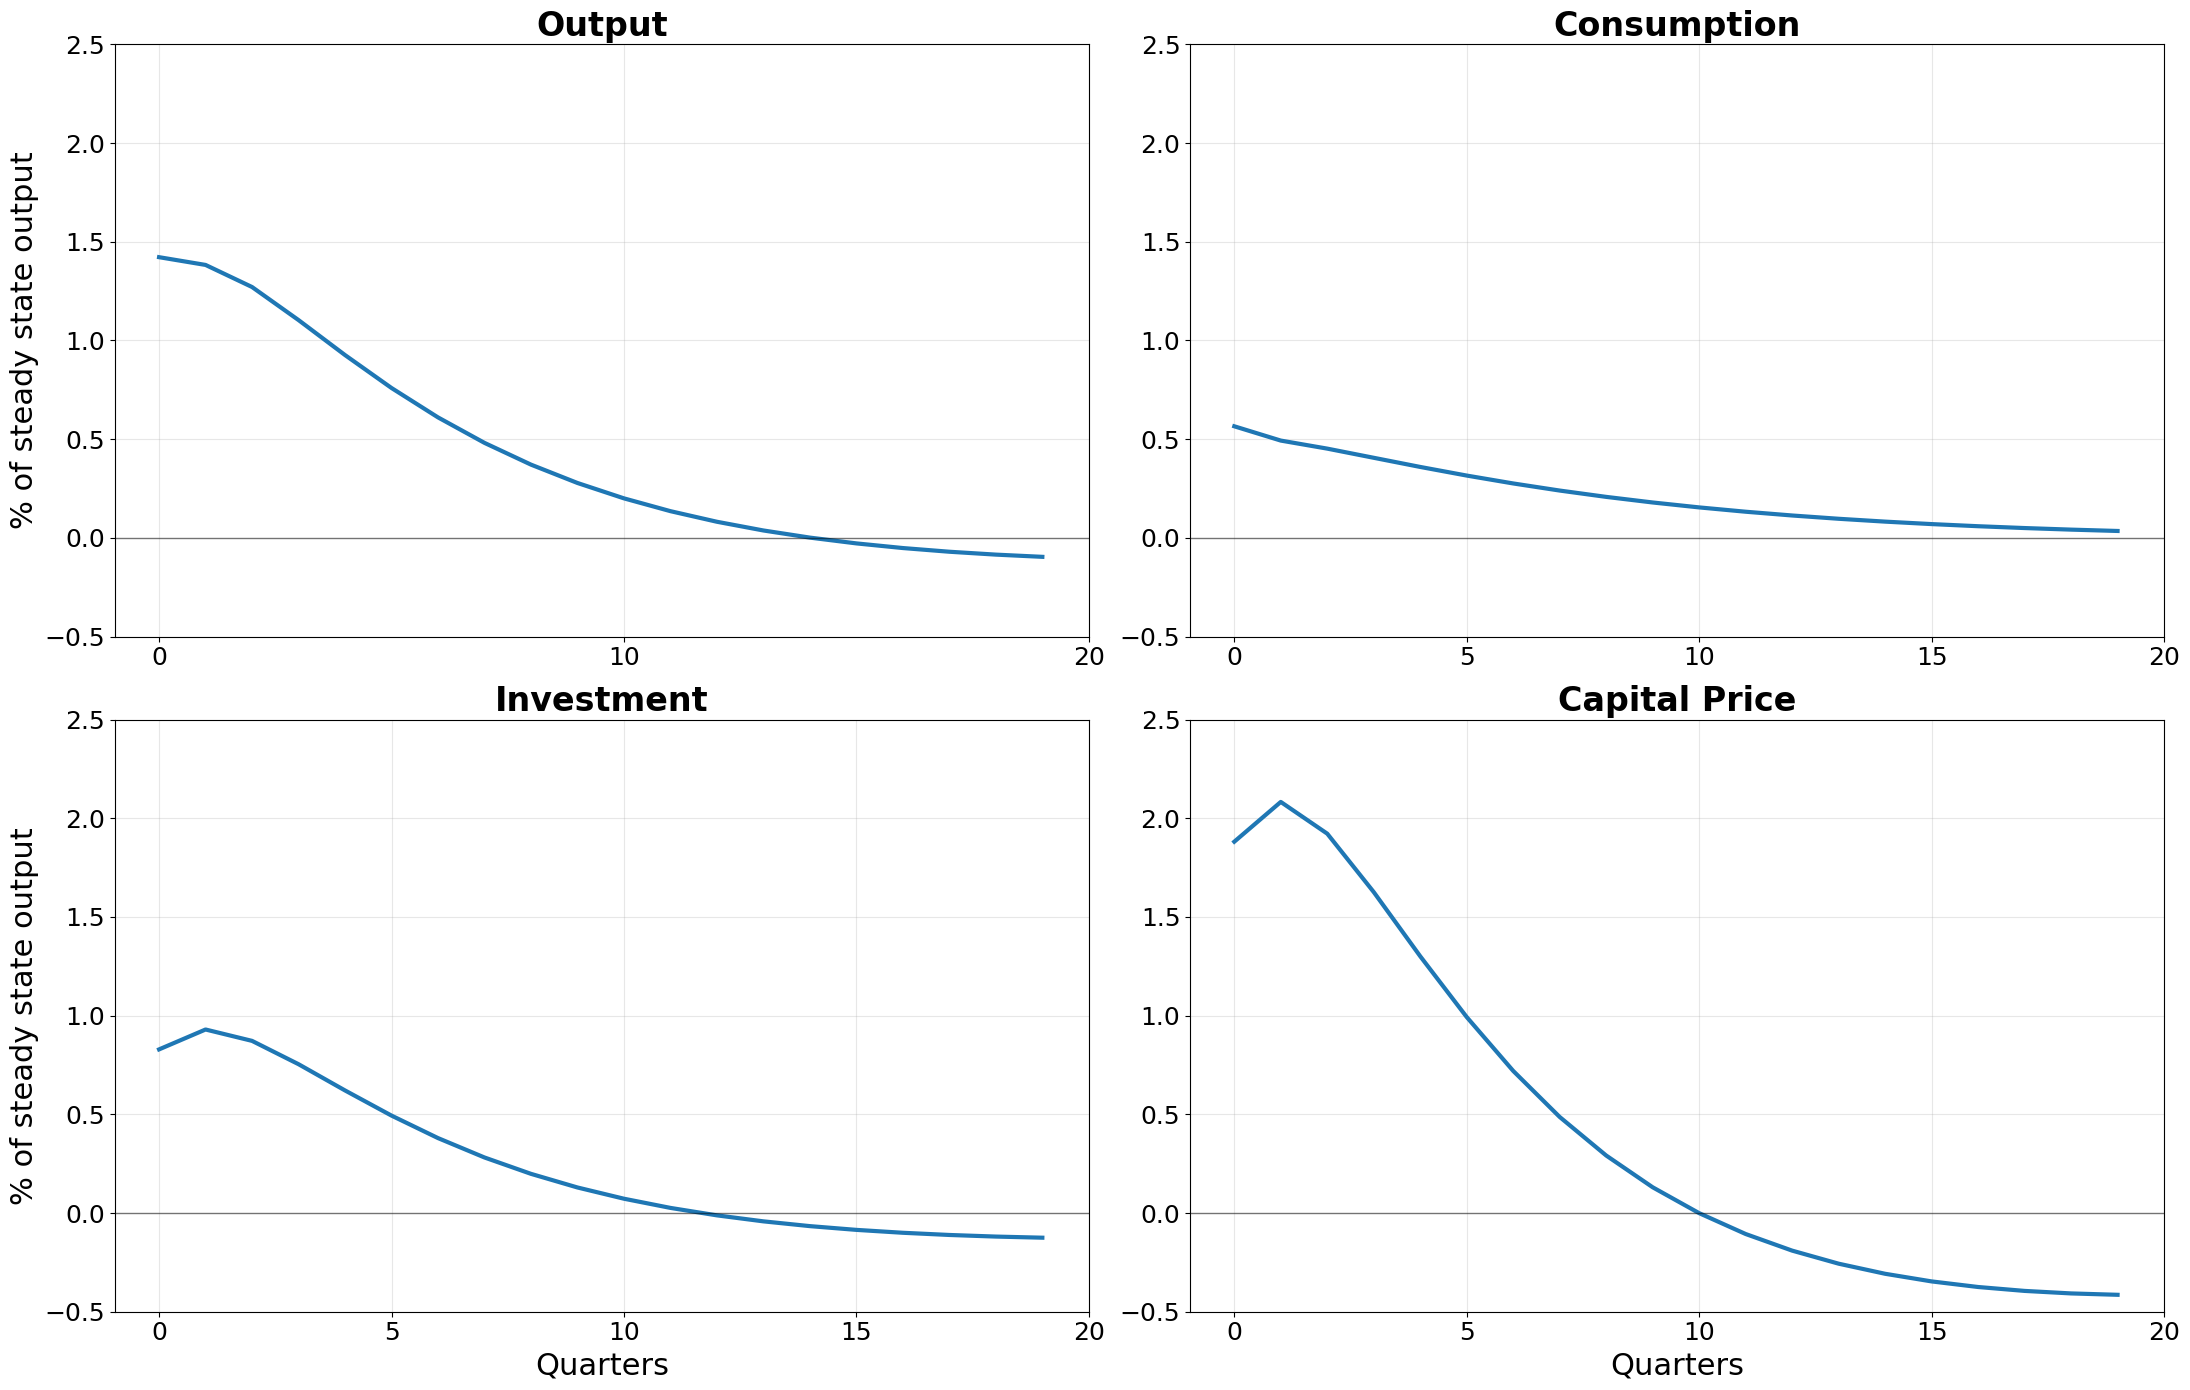

In [40]:


# Create 2x2 figure with 4 panels for macro variables
fig, axes = plt.subplots(2, 2, figsize=(22, 14))  # Changed to 2x2 layout with larger figure

T_plot = 20  # Number of periods to plot

# Extract total responses (no multiplication by 100)
dY_total = irfs['Y'][:T_plot]
dC_total = irfs['C'][:T_plot]
dI_total = irfs['I'][:T_plot]
dQ_total = irfs['Q'][:T_plot]

# Panel 1: Output (Y) - top-left
axes[0,0].plot(dY_total, linewidth=3)
axes[0,0].set_title('Output', fontsize=24, fontweight='bold')
axes[0,0].grid(True, alpha=0.3)
axes[0,0].axhline(y=0, color='black', linewidth=1, alpha=0.5)
axes[0,0].set_xticks([0, 10, 20])
axes[0,0].set_ylim(-0.5, 2.5)  # Set y-axis limits
axes[0,0].tick_params(axis='both', which='major', labelsize=18)
axes[0,0].set_ylabel('% of steady state output', fontsize=22)

# Panel 2: Consumption (C) - top-right
axes[0,1].plot(dC_total, linewidth=3)
axes[0,1].set_title('Consumption', fontsize=24, fontweight='bold')
axes[0,1].grid(True, alpha=0.3)
axes[0,1].axhline(y=0, color='black', linewidth=1, alpha=0.5)
axes[0,1].set_xticks([0, 5, 10, 15, 20])
axes[0,1].set_ylim(-0.5, 2.5)  # Set y-axis limits
axes[0,1].tick_params(axis='both', which='major', labelsize=18)

# Panel 3: Investment (I) - bottom-left
axes[1,0].plot(dI_total, linewidth=3)
axes[1,0].set_title('Investment', fontsize=24, fontweight='bold')
axes[1,0].grid(True, alpha=0.3)
axes[1,0].axhline(y=0, color='black', linewidth=1, alpha=0.5)
axes[1,0].set_xticks([0, 5, 10, 15, 20])
axes[1,0].set_ylim(-0.5, 2.5)  # Set y-axis limits
axes[1,0].tick_params(axis='both', which='major', labelsize=18)
axes[1,0].set_xlabel('Quarters', fontsize=22)
axes[1,0].set_ylabel('% of steady state output', fontsize=22)

# Panel 4: Capital Price (Q) - bottom-right
axes[1,1].plot(dQ_total, linewidth=3)
axes[1,1].set_title('Capital Price', fontsize=24, fontweight='bold')
axes[1,1].grid(True, alpha=0.3)
axes[1,1].axhline(y=0, color='black', linewidth=1, alpha=0.5)
axes[1,1].set_xticks([0, 5, 10, 15, 20])
axes[1,1].set_ylim(-0.5, 2.5)  # Set y-axis limits
axes[1,1].tick_params(axis='both', which='major', labelsize=18)
axes[1,1].set_xlabel('Quarters', fontsize=22)

plt.tight_layout()
plt.savefig('macro_irfs.svg', format='svg')
plt.savefig('macro_irfs.png', format='png', bbox_inches='tight', dpi=300)
plt.show()



In [34]:

print(irfs)


<ImpulseDict: ['n_gov', 'b_gov', 'Y', 'rk', 'goods_mkt', 'liquid_mkt', 'illiquid_mkt', 'A1', 'B1', 'C1', 'UCE1', 'ADJ_COST1', 'GINI_A1', 'GINI_B1', 'GINI_C1', 'GINI_WEALTH1', 'A2', 'B2', 'C2', 'UCE2', 'ADJ_COST2', 'GINI_A2', 'GINI_B2', 'GINI_C2', 'GINI_WEALTH2', 'C', 'A', 'B', 'ADJ_COST', 'UCE', 'GINI_A_TOTAL', 'GINI_B_TOTAL', 'GINI_C_TOTAL', 'GINI_WEALTH_TOTAL', 'theta_res', 'k_inter', 'k_gov', 'd', 'k_fund', 'rn', 'n_inter_val', 'A_sum', 'B_sum', 'ra', 'n_inter', 'theta', 'rk_res', 'capital_res', 'q_res', 'K', 'Q', 'I', 'N', 'w', 'T']>


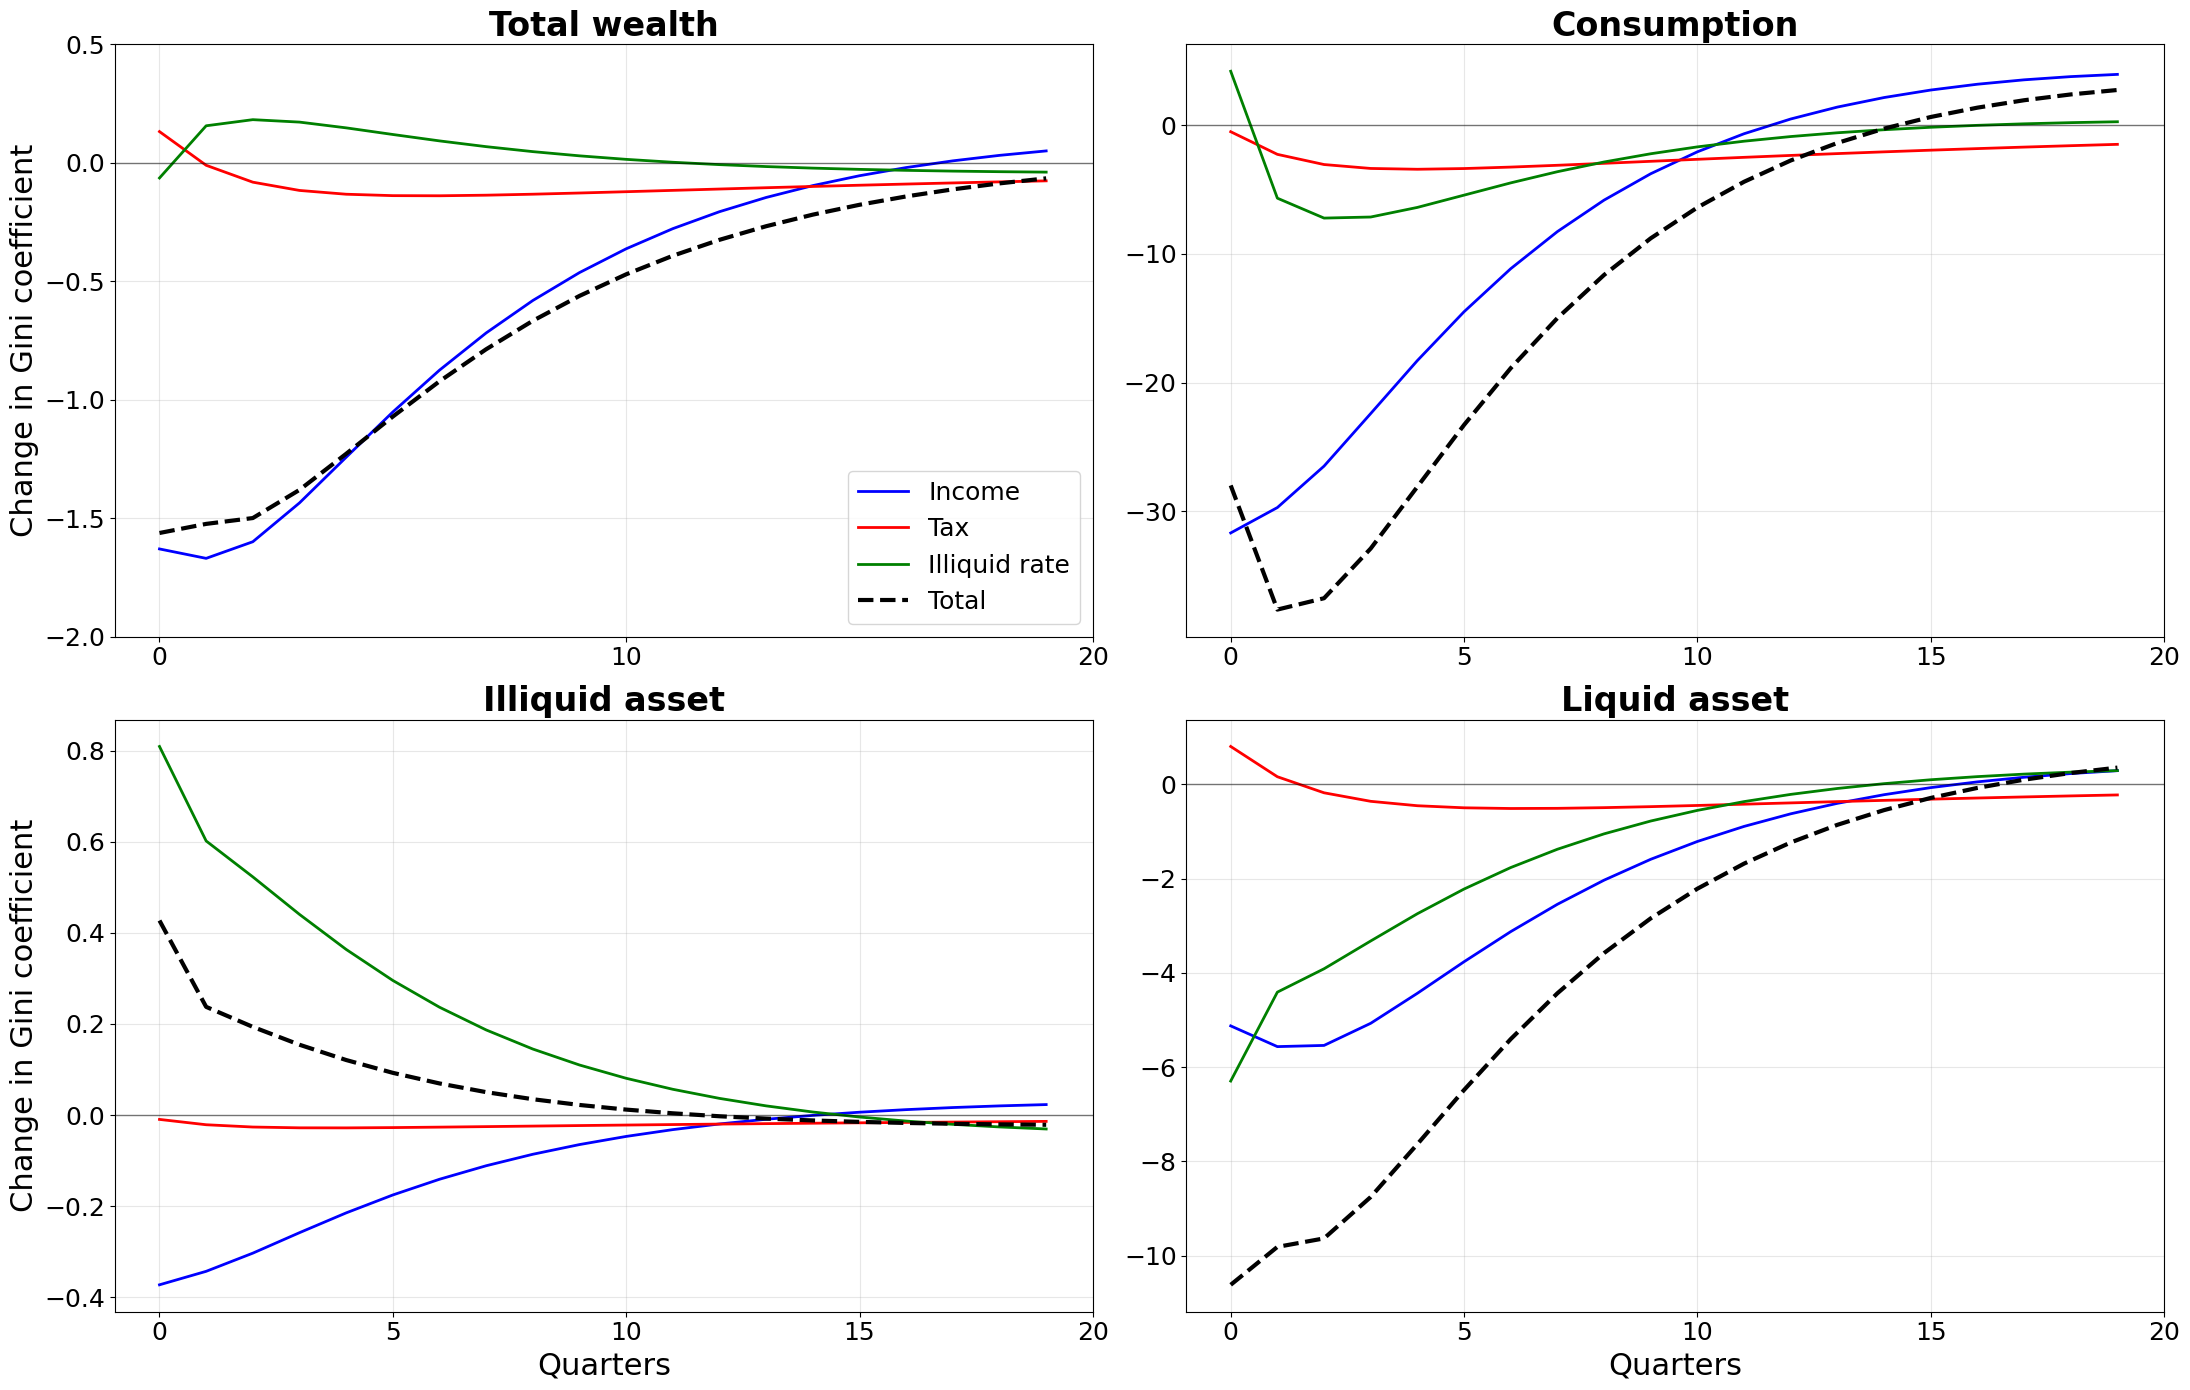

In [47]:
# First, calculate all the GINI decompositions (without rb effects)
# Extract all Jacobians
J_GINI_WEALTH_Y = J_ha['GINI_WEALTH_TOTAL']['Y']
J_GINI_WEALTH_T = J_ha['GINI_WEALTH_TOTAL']['T']
J_GINI_WEALTH_ra = J_ha['GINI_WEALTH_TOTAL']['ra']

J_GINI_C_Y = J_ha['GINI_C_TOTAL']['Y']
J_GINI_C_T = J_ha['GINI_C_TOTAL']['T']
J_GINI_C_ra = J_ha['GINI_C_TOTAL']['ra']

J_GINI_A_Y = J_ha['GINI_A_TOTAL']['Y']
J_GINI_A_T = J_ha['GINI_A_TOTAL']['T']
J_GINI_A_ra = J_ha['GINI_A_TOTAL']['ra']

J_GINI_B_Y = J_ha['GINI_B_TOTAL']['Y']
J_GINI_B_T = J_ha['GINI_B_TOTAL']['T']
J_GINI_B_ra = J_ha['GINI_B_TOTAL']['ra']

# Extract shocks from IRFs
dY = irfs['Y']
dT = irfs['T']
dra = irfs['ra']

# Calculate partial effects for Wealth GINI and multiply by 100
dGINI_WEALTH_Y = (J_GINI_WEALTH_Y @ dY) * 100
dGINI_WEALTH_T = (J_GINI_WEALTH_T @ dT) * 100
dGINI_WEALTH_ra = (J_GINI_WEALTH_ra @ dra) * 100

# Calculate partial effects for Consumption GINI and multiply by 100
dGINI_C_Y = (J_GINI_C_Y @ dY) * 100
dGINI_C_T = (J_GINI_C_T @ dT) * 100
dGINI_C_ra = (J_GINI_C_ra @ dra) * 100

# Calculate partial effects for Illiquid Asset GINI and multiply by 100
dGINI_A_Y = (J_GINI_A_Y @ dY) * 100
dGINI_A_T = (J_GINI_A_T @ dT) * 100
dGINI_A_ra = (J_GINI_A_ra @ dra) * 100

# Calculate partial effects for Liquid Asset GINI and multiply by 100
dGINI_B_Y = (J_GINI_B_Y @ dY) * 100
dGINI_B_T = (J_GINI_B_T @ dT) * 100
dGINI_B_ra = (J_GINI_B_ra @ dra) * 100

# Total GINI responses from IRFs and multiply by 100
dGINI_WEALTH_total = irfs['GINI_WEALTH_TOTAL'] * 100
dGINI_C_total = irfs['GINI_C_TOTAL'] * 100
dGINI_A_total = irfs['GINI_A_TOTAL'] * 100
dGINI_B_total = irfs['GINI_B_TOTAL'] * 100

# ...existing code...

# Create 2x2 figure with 4 panels
fig, axes = plt.subplots(2, 2, figsize=(22, 14))  # Changed to 2x2 layout

T_plot = 20  # Number of periods to plot

# Panel 1: Wealth GINI (top-left)
axes[0,0].plot(dGINI_WEALTH_Y[:T_plot], 'b-', linewidth=2, label='Income')
axes[0,0].plot(dGINI_WEALTH_T[:T_plot], 'r-', linewidth=2, label='Tax')
axes[0,0].plot(dGINI_WEALTH_ra[:T_plot], 'g-', linewidth=2, label='Illiquid rate')
axes[0,0].plot(dGINI_WEALTH_total[:T_plot], 'k--', linewidth=3, label='Total')
axes[0,0].set_title('Total wealth', fontsize=24, fontweight='bold')
axes[0,0].legend(fontsize=18)
axes[0,0].grid(True, alpha=0.3)
axes[0,0].axhline(y=0, color='black', linewidth=1, alpha=0.5)
axes[0,0].set_xticks([0, 10, 20])
axes[0,0].set_yticks(axes[0,0].get_yticks()[::2])  # Keep every other y-tick
axes[0,0].tick_params(axis='both', which='major', labelsize=18)
axes[0,0].set_ylabel('Change in Gini coefficient', fontsize=22)

# Panel 2: Consumption GINI (top-right)
axes[0,1].plot(dGINI_C_Y[:T_plot], 'b-', linewidth=2)
axes[0,1].plot(dGINI_C_T[:T_plot], 'r-', linewidth=2)
axes[0,1].plot(dGINI_C_ra[:T_plot], 'g-', linewidth=2)
axes[0,1].plot(dGINI_C_total[:T_plot], 'k--', linewidth=3)
axes[0,1].set_title('Consumption', fontsize=24, fontweight='bold')
axes[0,1].grid(True, alpha=0.3)
axes[0,1].axhline(y=0, color='black', linewidth=1, alpha=0.5)
axes[0,1].set_xticks([0, 5, 10, 15, 20])
axes[0,1].tick_params(axis='both', which='major', labelsize=18)

# Panel 3: Illiquid Asset GINI (bottom-left)
axes[1,0].plot(dGINI_A_Y[:T_plot], 'b-', linewidth=2)
axes[1,0].plot(dGINI_A_T[:T_plot], 'r-', linewidth=2)
axes[1,0].plot(dGINI_A_ra[:T_plot], 'g-', linewidth=2)
axes[1,0].plot(dGINI_A_total[:T_plot], 'k--', linewidth=3)
axes[1,0].set_title('Illiquid asset', fontsize=24, fontweight='bold')
axes[1,0].grid(True, alpha=0.3)
axes[1,0].axhline(y=0, color='black', linewidth=1, alpha=0.5)
axes[1,0].set_xticks([0, 5, 10, 15, 20])
axes[1,0].tick_params(axis='both', which='major', labelsize=18)
axes[1,0].set_xlabel('Quarters', fontsize=22)
axes[1,0].set_ylabel('Change in Gini coefficient', fontsize=22)

# Panel 4: Liquid Asset GINI (bottom-right)
axes[1,1].plot(dGINI_B_Y[:T_plot], 'b-', linewidth=2)
axes[1,1].plot(dGINI_B_T[:T_plot], 'r-', linewidth=2)
axes[1,1].plot(dGINI_B_ra[:T_plot], 'g-', linewidth=2)
axes[1,1].plot(dGINI_B_total[:T_plot], 'k--', linewidth=3)
axes[1,1].set_title('Liquid asset', fontsize=24, fontweight='bold')
axes[1,1].grid(True, alpha=0.3)
axes[1,1].axhline(y=0, color='black', linewidth=1, alpha=0.5)
axes[1,1].set_xticks([0, 5, 10, 15, 20])
axes[1,1].tick_params(axis='both', which='major', labelsize=18)
axes[1,1].set_xlabel('Quarters', fontsize=22)

plt.tight_layout()
plt.savefig('gini_decomp.svg', format='svg')
plt.savefig('gini_decomp.png', format='png', bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
dY = {}

dC


dGINI_WEALTH_drb = J_ha['GINI_WEALTH_TOTAL']['rb'] @ drb  # liquid asset rate
dGINI_WEALTH_dra = J_ha['GINI_WEALTH_TOTAL']['ra'] @ dra  # illiquid asset rate
dGINI_WEALTH_dT = J_ha['GINI_WEALTH_TOTAL']['T'] @ dT 
dGINI_WEALTH_dT = J_ha['GINI_WEALTH_TOTAL']['T'] @ dY 

NameError: name 'drb' is not defined

---


In [ ]:
# now go below... 

last_T = 250 # we'll calculate household responses up to T


ys = np.outer(1 + 0.01*(np.arange(T) == 5), ss['y'])

Va = ss['Va'] # initialize with steady-state marginal value function
a, c = [np.empty((T,) + ss['a'].shape) for _ in range(2)] # empty arrays to store a and c paths
ss_inputs = {k: ss[k] for k in ('Pi', 'a_grid', 'r', 'beta', 'eis')} # dict of non-changing ss inputs
for t in reversed(range(T)):
    Va, a[t], c[t] = sim.backward_iteration(Va=Va, y=ys[t], **ss_inputs)

In [38]:
@simple
def taylor (rstar, phi, pi):
    #Taylor Rule
    i = rstar +phi*pi
    return i

@simple 
def fisher (i, pi):
    #Fisher Equation
    rb = ((1+ i(-1))/(1+pi))-1
    return rb

@simple
def wage(pi, w, N,tax):
    #Wage inflation
    piw = (1 + pi) * w / w(-1) - 1
    T = tax*w*N
    return piw, t 

In [39]:
@simple
def union(piw, N, tax, w, UCE, kappaw, muw, vphi, frisch, beta):
    #Wage New Keynesian Philips Curve
    wnkpc = kappaw * (vphi * N ** (1 + 1 / frisch) - (1 - tax) * w * N * UCE / muw) + beta * \
            (1 + piw(+1)).apply(np.log) - (1 + piw).apply(np.log)
    return wnkpc

In [40]:
# Clearing Conditions

@simple
def market_clearing(Y, C, I, G, B_sum, B, A_sum, A, K,):
    #Goods Market Clearing Condition
    goods_mkt = Y-C-I-G 

    #Liquid Asset Market Clearing Condition
    liquid_mkt = B_sum-B

    #Illiquid Asset Market Clearing Condition
    illiquid_mkt = A_sum-A

    return goods_mkt, liquid_mkt, illiquid_mkt 


### Steady State

In [ ]:
@simple ### i added this one
def smart_steady(A_sum,  B_sum, theta, Y,  T, n_inter,  rb, alpha, delta, f):

    # this is copied from the Julia code
    d = (theta-1)*n_inter
    K = A_sum + d
    rk = alpha * Y/K - delta
    m = n_inter*(1-(1-f)*(1 + rb+ theta*(rk-rb)))
    k_inter = theta*n_inter
    k_fund = K - k_inter
    ra = (rk - rb) / (1- d / K) + rb
    I = K*delta 
    b_gov_val = B_sum - d
    G = T -  rb * b_gov_val

    return  d, K, rk, m, k_inter, k_fund, ra, I, b_gov_val, G

In [10]:

@simple
def market_clearing(Y, C, I, G, B_sum, B, A_sum, A):
    #Goods Market Clearing Condition
    goods_mkt = Y-C-I-G 

    #Liquid Asset Market Clearing Condition
    liquid_mkt = B_sum-B

    #Illiquid Asset Market Clearing Condition
    illiquid_mkt = A_sum-A

    return goods_mkt, liquid_mkt, illiquid_mkt 


In [ ]:
# @simple 
# def params_steady (r, alpha, K, Y, N, ksi, rb, n_inter, f, theta, T, w, delta):
#     Z = Y * K ** (-alpha) * N ** (alpha - 1)
#     gamma0 = delta**ksi
#     gamma1 = 0
#     rstar = rb
#     tax = T/(w*N)
#     i = rstar
#     return Z, gamma0, gamma1, rstar, tax, i 

## Solving

In [5]:
hh = hetblocks.hh_twoasset.hh
hh_ext = hh.add_hetinputs([income, make_grids])

### Helper

In [6]:
blocks = [hh_ext]
hank_hh = create_model(blocks, name='Two-Asset HANK HH')
print(*hank_hh.blocks, sep='\n')

print(f"Inputs: {hank_hh.inputs}")
print(f"Outputs: {hank_hh.outputs}")

<HetBlock 'hh' with hetinput 'make_grids_marginal_cost_grid' and with hetoutput `adjustment_costs'>
Inputs: ['beta', 'eis', 'rb', 'ra', 'chi0', 'chi1', 'chi2', 'T', 'Y', 'alpha', 'bmax', 'amax', 'kmax', 'nB', 'nA', 'nK', 'nZ', 'rho_z', 'sigma_z']
Outputs: ['A', 'B', 'C', 'UCE', 'CHI']


In [37]:
calibration_hh = {
               'rb': 0.01,
               'ra': 0.02,
               'chi0': 0.25,
               'chi1': 10.5,
               'chi2': 2.0,
                'beta': 0.965,
                'T': 0.2,
                'eis': 0.5,
                'w': 0.7,
                'N' : 1.0,
                'Y': 1.0,
                'alpha': 0.3,
               'nZ': 3,
               'nB': 50,
               'nA': 70,
               'nK': 50,
               'bmax': 50,
               'amax': 2000,
               'kmax': 1,
               'rho_z': 0.966, 
               'sigma_z': 0.92}

ssh = hank_hh.steady_state(calibration_hh)

print(calibration_hh)
print(ssh)
print(f"A: {ssh['A']}")
print(f"B: {ssh['B']}")
print(f"C: {ssh['C']}")
print(f"UCE: {ssh['UCE']}")
print(f"CHI: {ssh['CHI']}")
#print(f"z_grid: {ssh.internals['hh']['z_grid']}")

{'rb': 0.01, 'ra': 0.02, 'chi0': 0.25, 'chi1': 10.5, 'chi2': 2.0, 'beta': 0.965, 'T': 0.2, 'eis': 0.5, 'w': 0.7, 'N': 1.0, 'Y': 1.0, 'alpha': 0.3, 'nZ': 3, 'nB': 50, 'nA': 70, 'nK': 50, 'bmax': 50, 'amax': 2000, 'kmax': 1, 'rho_z': 0.966, 'sigma_z': 0.92}
<SteadyStateDict: ['beta', 'eis', 'rb', 'ra', 'chi0', 'chi1', 'chi2', 'T', 'Y', 'alpha', 'bmax', 'amax', 'kmax', 'nB', 'nA', 'nK', 'nZ', 'rho_z', 'sigma_z', 'A', 'B', 'C', 'UCE', 'CHI'], internals=['hh']>
A: 13.344828302576508
B: 0.8240540554588738
C: 0.7383635715519268
UCE: 2.950333593919545
CHI: 0.03677357213458667


In [44]:
blocks_ss = [smart_steady]
hank_ss = create_model(blocks_ss, name='Two-Asset HANK SS')
calibration = {
               'rb': 0.01,
               'ra': 0.02,
               'chi0': 0.25,
               'chi1': 10.5,
               'chi2': 2.0,
                'beta': 0.965,
                'T': 0.2,
                'eis': 0.5,
                'w': 0.7,
                'N' : 1.0,
                'Y': 1.0,
                'alpha': 0.3,
               'nZ': 3,
               'nB': 50,
               'nA': 70,
               'nK': 50,
               'bmax': 50,
               'amax': 2000,
               'kmax': 1,
               'rho_z': 0.966, 
               'sigma_z': 0.92,
                'theta':4,
                'B_sum': 1.529593378821584,
                'A_sum': 10.604099976251634,
                'beta': 0.965,
                 'chi1': 10.5,
                'delta': 0.025,

                'f': 0.06,
                'theta': 4,
                'frisch': 1,
                'Y': 1,
                #'Q': targets["Q"],
                'n_inter': targets["n_inter"],
                'muw':1.1,
                'ksi': 0.5
               }
ssh = hank_ss.steady_state(calibration)


print(f"ra: {ssh['ra']}")


ra: -0.0018580076998911312


In [36]:
blocks_ss = [smart_steady, steady_auxilliary, hh_ext, market_clearing]

hank_ss = create_model(blocks_ss, name='Two-Asset HANK SS')

print(hank_ss)
print(f"Inputs: {hank_ss.inputs}")
print(f"Outputs: {hank_ss.outputs}")


calibration = {
               'rb': 0.01,
               'ra': 0.02,
               'chi0': 0.25,
               'chi1': 10.5,
               'chi2': 2.0,
                'beta': 0.965,
                'T': 0.2,
                'eis': 0.5,
                'w': 0.7,
                'N' : 1.0,
                'Y': 1.0,
                'alpha': 0.3,
               'nZ': 3,
               'nB': 50,
               'nA': 70,
               'nK': 50,
               'bmax': 50,
               'amax': 2000,
               'kmax': 1,
               'rho_z': 0.966, 
               'sigma_z': 0.92,

                'theta':4,
                'B_sum': 1.529593378821584,
                'A_sum': 10.604099976251634,
                'beta': 0.965,
                 'chi1': 10.5,
                'delta': 0.025,

                'f': 0.06,
                'theta': 4,
                'frisch': 1,
                'Y': 1,
                #'Q': targets["Q"],
                'n_inter': targets["n_inter"],
                'muw':1.1,
                'ksi': 0.5
               }




ssh = hank_ss.steady_state(calibration)


print(f"goods_mkt: {ssh['goods_mkt']}")
print(f"liquid_mkt: {ssh['liquid_mkt']}")
print(f"illiquid_mkt: {ssh['illiquid_mkt']}")


<Model 'Two-Asset HANK SS'>
Inputs: ['A_sum', 'B_sum', 'theta', 'Y', 'T', 'n_inter', 'rb', 'alpha', 'delta', 'f', 'beta', 'eis', 'chi0', 'chi1', 'chi2', 'bmax', 'amax', 'kmax', 'nB', 'nA', 'nK', 'nZ', 'rho_z', 'sigma_z']
Outputs: ['d', 'K', 'rk', 'm', 'k_inter', 'k_fund', 'ra', 'I', 'b_gov_val', 'G', 'iota', 'gamma', 'mpk', 'rn', 'A', 'B', 'C', 'UCE', 'CHI', 'goods_mkt', 'liquid_mkt', 'illiquid_mkt']
goods_mkt: -0.0621336180761248
liquid_mkt: -4.243111574592016
illiquid_mkt: 10.604099976251634


### Solve for the steady state of the model

In [ ]:
# blocks = [hh_ext, capital_solved, investment, labor, intermediation_solved,
#           taylor, fisher, wage, government_solved, union,market_clearing]

# hank = create_model(blocks, name='Two-Asset HANK')

# print(*hank.blocks, sep='\n')

NameError: name 'capital_solved' is not defined

<Model 'Two-Asset HANK SS'>
Inputs: ['theta0', 'n_inter', 'A_sum', 'alpha', 'Y', 'delta', 'f', 'rb', 'T', 'B_sum', 'b_gov', 'w', 'N', 'muw', 'frisch', 'ksi', 'beta', 'eis', 'chi0', 'chi1', 'chi2', 'bmax', 'amax', 'kmax', 'nB', 'nA', 'nK', 'nZ', 'rho_z', 'sigma_z']
Outputs: ['theta', 'd', 'K', 'r', 'm', 'k_inter', 'k_fund', 'ra', 'I', 'b_gov_val', 'G', 'iota', 'gamma', 'mpk', 'rn', 'vphi', 'wnkpc', 'Z', 'gamma0', 'gamma1', 'rstar', 'tax', 'i', 'A', 'B', 'C', 'UCE', 'CHI', 'goods_mkt', 'liquid_mkt', 'illiquid_mkt']


In [ ]:
calibration = {'rb': 0.01,
               'ra': 0.02,
               'chi0': 0.25,
               'chi2': 2.0,
                'T': 0.2,
                'eis': 0.5,
                'w': 0.7,
                'N': 1.0,
                'alpha': 0.3,
                'nZ': 33,
                'nB': 50,
                'nA': 70,
                'nK': 50,
                'bmax': 50,
                'amax': 2000,
                'kmax': 1,
                'rho_z': 0.966, 
                'sigma_z': 0.92,
                'theta0':4,

                #Zdaja sie być 'for the time being' relatywnie sensowne tagety
                'B': 1.529593378821584,
                'B_sum': 1.529593378821584,
                'A_sum': 10.604099976251634,
               
                'delta': 0.025,

                'f': 0.06,
                'theta': 4,
                'frisch': 1,
                'Y': 1,
                #'Q': targets["Q"],
                'n_inter': targets["n_inter"],
                'rb': targets["rb"], 
                'muw':1.1,
                'b_gov': 0, 
                'ksi': 0.5
               }

unknowns_ss = {'beta': 0.965, 'chi1': 10.5}
targets_ss = {'illiquid_mkt': 0., 'liquid_mkt':0.}

cali = hank_ss.solve_steady_state(calibration, unknowns_ss, targets_ss, solver='broyden_custom')

LinAlgError: Singular matrix

In [ ]:
ss =  hank.steady_state(cali)

print(f"Liquid assets: {ss['B']: 0.2f}")
print(f"Asset market clearing: {ss['asset_mkt']: 0.2e}")
print(f"Goods market clearing (untargeted): {ss['goods_mkt']: 0.2e}")

In [ ]:
exogenous = ['rstar', 'Z', 'G']
unknowns = ['r', 'w', 'Y']
targets = ['asset_mkt', 'fisher', 'wnkpc']
T = 300

J_ha = hh_ext.jacobian(ss, inputs=['N', 'r', 'ra', 'rb', 'tax', 'w'], T=T)
G = hank.solve_jacobian(ss, unknowns, targets, exogenous, T=T, Js={'hh': J_ha})

# Results

In [ ]:
%time G = hank.solve_jacobian(ss, unknowns, targets, exogenous, T=T, Js={'hh': J_ha})

In [ ]:
%time G = hank.solve_jacobian(ss, unknowns, targets, exogenous, T=T)

In [ ]:
from sequence_jacobian.classes import FactoredJacobianDict

H_U = hank.jacobian(ss, unknowns, targets, T=T, Js={'hh': J_ha})
H_U_factored = FactoredJacobianDict(H_U, T)

In [ ]:
%time G = hank.solve_jacobian(ss, unknowns, targets, exogenous, T=T, Js={'hh': J_ha}, H_U_factored=H_U_factored)

In [ ]:
rhos = np.array([0.2, 0.4, 0.6, 0.8])
drstar = -0.0025 * rhos ** (np.arange(T)[:, np.newaxis])
dra = 100 * G['ra']['rstar'] @ drstar

plt.plot(dra[:21])
plt.title(r'Output response to 25 bp monetary policy shocks with $\rho=(0.2 ... 0.8)$')
plt.xlabel('quarters')
plt.ylabel('% deviation from ss')
plt.show()

### JUNK YARD 